In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import basinhopping
from iminuit import Minuit

import emcee
from pprint import pprint
import time
from multiprocessing import Pool

import random

## 2006 统计分析

In [3]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_06(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata06 = pd.read_csv("perlist06_s.csv")
    f = perdata06['f']
    per = perdata06['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata06)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [4]:
m06=Minuit(twi_minus_loglikelihood_06,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.06,error_poisson=0.06,
         limit_log_A=(-3,-1), limit_log_f_b=(-5,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,2),
         errordef=1)

m06.migrad()

pprint(m06.fval)

FCN = -1236.9677578079807 
 TOTAL NCALL = 159 
 NCALLS = 159 
 
 
 EDM = 1.989476009735364e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-2.29215,0.158339,,,-3,-1,No
1,log_f_b,-3.86704,0.136486,,,-5,-2,No
2,alpha_H,3.3068,0.348349,,,1,5,No
3,poisson,0.168015,0.00554297,,,0,2,No


-1236.9677578079807


In [5]:
perdata06 = pd.read_csv("perlist06_s.csv")
f_06 = perdata06['f']
per_06 = perdata06['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m06.values[0],m06.values[1],m06.values[2],m06.values[3]

model_06 = []
R_obs_06 = []
T_SSE_obs_06 = 0
f_length_06 = len(f_06)
for i in range(f_length_06):
    model_06.append(((f_06[i]**(-alpha_L))/(1+(f_06[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_06.append(2*per_06[i]/model_06[i])
    T_SSE_obs_06 += (((per_06[i]-model_06[i])/model_06[i])**2)
    
# 两个统计量
T_R_obs_06 = max(R_obs_06)
print ("T_R =", T_R_obs_06)
print ("T_SSE =", T_SSE_obs_06)

T_R = 13.695484867237228
T_SSE = 1073.8175500319135


In [6]:
# 5000条光变曲线

df = 0.01/f_length_06
N = 2*f_length_06
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_06]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_06):
        R_simu.append(2*per_simu[i]/model_06[i])
        T_SSE_simu += (((per_simu[i]-model_06[i])/model_06[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_06:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_06:
        n_TSSE += 1

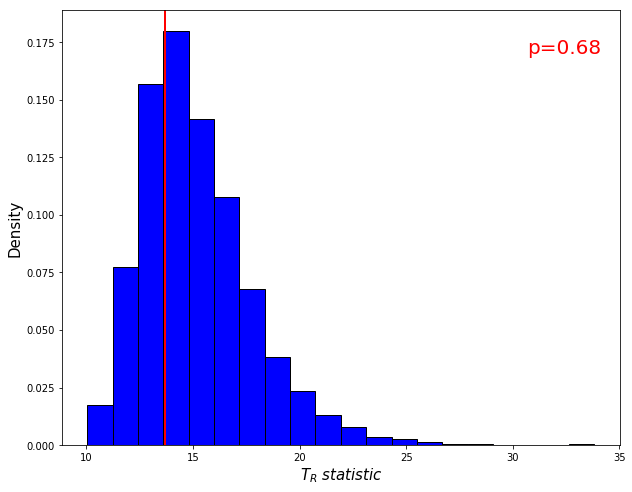

In [7]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_06, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

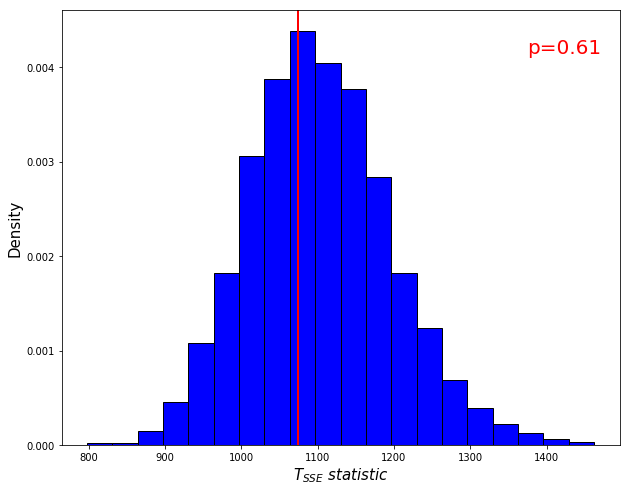

In [8]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_06, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2006 模型比较

In [9]:
def twi_minus_loglikelihood_nobreak_06(log_A,alpha,poisson):
    alpha_L = 1.0
    
    perdata06 = pd.read_csv("perlist06_s.csv")
    f = perdata06['f']
    per = perdata06['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append((f[i]**(-alpha))*(10**log_A)+poisson)
     
    
    length = len(perdata06)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [10]:
n06=Minuit(twi_minus_loglikelihood_nobreak_06,log_A=-9,alpha=2.0,poisson=1.0,
         error_log_A=0.1,error_alpha=0.01,error_poisson=0.01,
         limit_log_A=(-11,-8),limit_alpha=(1.0,5.0),limit_poisson=(0,2),
         errordef=1)

n06.migrad()

print(n06.fval)

FCN = -1221.8371800910923 
 TOTAL NCALL = 232 
 NCALLS = 232 
 
 
 EDM = 6.736671680230015e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-8.56581,0.449877,,,-11,-8,No
1,alpha,2.50627,0.130531,,,1,5,No
2,poisson,0.164367,0.00553107,,,0,2,No


-1221.8371800910923


15.13057771688841


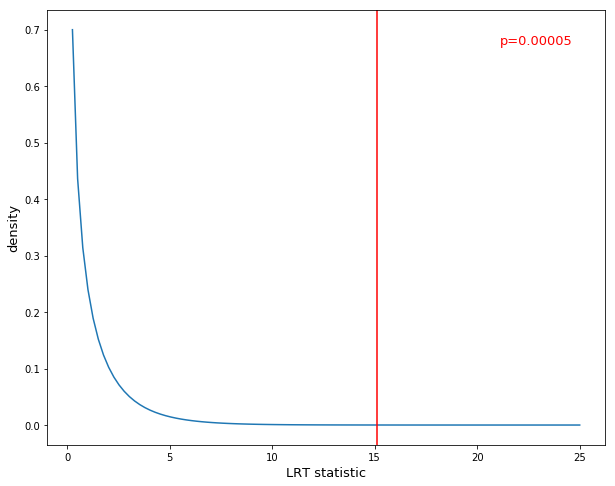

In [11]:
import scipy.stats as stats

# LRT statistic
T = n06.fval-m06.fval
print(T)

p = stats.chi2.pdf(T,1)
p1 = ("%.5f" % p)
plt.figure(figsize=(10,8))
plt.plot(np.linspace(0,25,100),stats.chi2.pdf(np.linspace(0,25,100),df=1))
plt.axvline(T,color="r")
plt.text(0.8,0.85,'p=%s'%p1,color='red',ha='center',transform=ax.transAxes,fontsize=13)
plt.xlabel("LRT statistic",fontsize=13)
plt.ylabel("density",fontsize=13)
plt.show()

## 2009(1) 统计分析

In [12]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_091(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata091 = pd.read_csv("perlist091_s.csv")
    f = perdata091['f']
    per = perdata091['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata091)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [13]:
m091=Minuit(twi_minus_loglikelihood_091,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.06,error_poisson=0.06,
         limit_log_A=(-3,-1), limit_log_f_b=(-5,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,2),
         errordef=1)

m091.migrad()

pprint(m091.fval)

FCN = 3227.130394485516 
 TOTAL NCALL = 517 
 NCALLS = 517 
 
 
 EDM = 5.687903179365203e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.13809,0.380473,,,-3,-1,No
1,log_f_b,-4.66228,0.398158,,,-5,-2,No
2,alpha_H,2.57134,0.277331,,,1,5,No
3,poisson,1.62539,0.055089,,,0,2,No


3227.130394485516


In [14]:
perdata091 = pd.read_csv("perlist091_s.csv")
f_091 = perdata091['f']
per_091 = perdata091['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m091.values[0],m091.values[1],m091.values[2],m091.values[3]

model_091 = []
R_obs_091 = []
T_SSE_obs_091 = 0
f_length_091 = len(f_091)
for i in range(f_length_091):
    model_091.append(((f_091[i]**(-alpha_L))/(1+(f_091[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_091.append(2*per_091[i]/model_091[i])
    T_SSE_obs_091 += (((per_091[i]-model_091[i])/model_091[i])**2)
    
# 两个统计量
T_R_obs_091 = max(R_obs_091)
print ("T_R =", T_R_obs_091)
print ("T_SSE =", T_SSE_obs_091)

T_R = 18.174752585231865
T_SSE = 1107.4909680694195


In [15]:
# 5000条光变曲线

df = 0.01/f_length_091
N = 2*f_length_091
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_091]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_091):
        R_simu.append(2*per_simu[i]/model_091[i])
        T_SSE_simu += (((per_simu[i]-model_091[i])/model_091[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_091:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_091:
        n_TSSE += 1

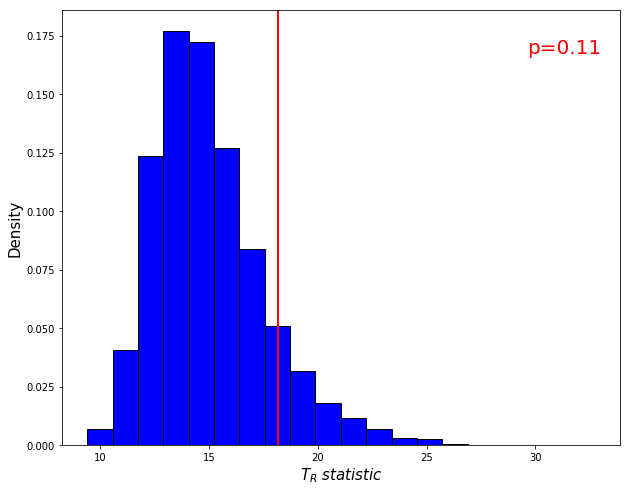

In [16]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_091, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

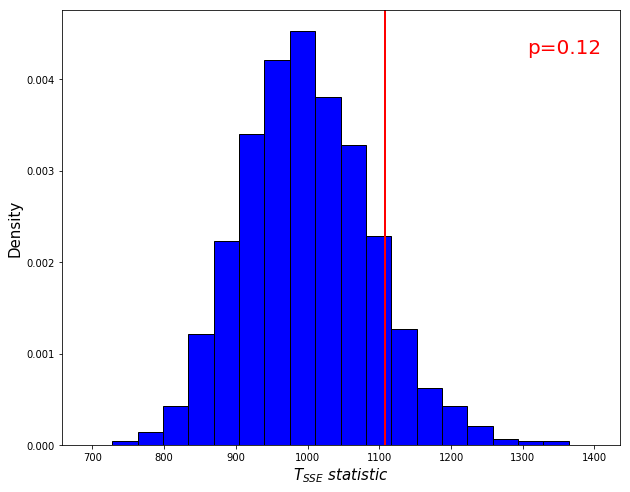

In [17]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_091, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2009(1) 模型比较

In [18]:
def twi_minus_loglikelihood_nobreak_091(log_A,alpha,poisson):
    alpha_L = 1.0
    
    perdata091 = pd.read_csv("perlist091_s.csv")
    f = perdata091['f']
    per = perdata091['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append((f[i]**(-alpha))*(10**log_A)+poisson)
     
    
    length = len(perdata091)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [19]:
n091=Minuit(twi_minus_loglikelihood_nobreak_091,log_A=-7,alpha=2.0,poisson=1.0,
         error_log_A=0.1,error_alpha=0.01,error_poisson=0.01,
         limit_log_A=(-9,-6),limit_alpha=(1.0,5.0),limit_poisson=(0,2),
         errordef=1)

n091.migrad()

pprint(n091.fval)

FCN = 3228.0089990629417 
 TOTAL NCALL = 115 
 NCALLS = 115 
 
 
 EDM = 6.970562978331368e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-7.78021,0.608763,,,-9,-6,No
1,alpha,2.37725,0.164889,,,1,5,No
2,poisson,1.61815,0.0548703,,,0,2,No


3228.0089990629417


0.8786045774259037


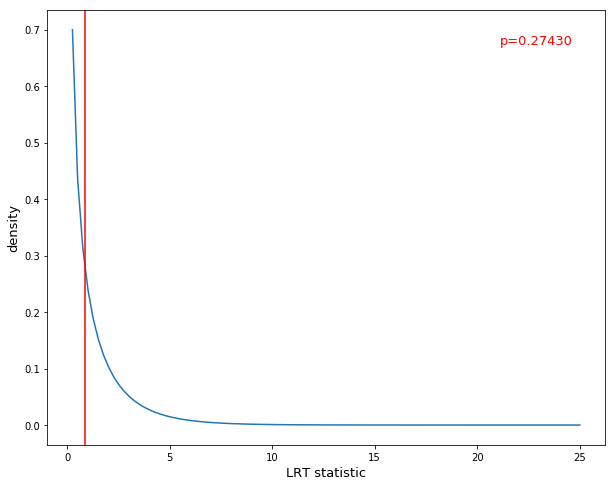

In [20]:
import scipy.stats as stats

# LRT statistic
T = n091.fval-m091.fval
print(T)

p = stats.chi2.pdf(T,1)
p1 = ("%.5f" % p)
plt.figure(figsize=(10,8))
plt.plot(np.linspace(0,25,100),stats.chi2.pdf(np.linspace(0,25,100),df=1))
plt.axvline(T,color="r")
plt.text(0.8,0.85,'p=%s'%p1,color='red',ha='center',transform=ax.transAxes,fontsize=13)
plt.xlabel("LRT statistic",fontsize=13)
plt.ylabel("density",fontsize=13)
plt.show()

## 2009(2) 统计分析

In [21]:
# 似然函数 p; D = -2 ln p

def twi_minus_loglikelihood_092(log_A,log_f_b,alpha_H,poisson):
    alpha_L = 1.0
    
    perdata092 = pd.read_csv("perlist092_s.csv")
    f = perdata092['f']
    per = perdata092['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append(((f[i]**(-alpha_L))/(1+(f[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
     
    
    length = len(perdata092)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [22]:
m092=Minuit(twi_minus_loglikelihood_092,log_A=math.log(0.005,10),log_f_b=math.log(1.7E-4,10),alpha_H=3.8,poisson=0.8,
         error_log_A=0.1,error_log_f_b=0.1,error_alpha_H=0.06,error_poisson=0.06,
         limit_log_A=(-3,-1), limit_log_f_b=(-5,-2),limit_alpha_H=(1.0,5.0),limit_poisson=(0,2),
         errordef=1)

m092.migrad()

pprint(m092.fval)

FCN = 2866.8147372376447 
 TOTAL NCALL = 477 
 NCALLS = 477 
 
 
 EDM = 6.528366464706828e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-1.14495,0.410471,,,-3,-1,No
1,log_f_b,-4.59308,0.393331,,,-5,-2,No
2,alpha_H,2.82922,0.384032,,,1,5,No
3,poisson,1.96469,0.0716793,,,0,2,No


2866.8147372376447


In [23]:
perdata092 = pd.read_csv("perlist092_s.csv")
f_092 = perdata092['f']
per_092 = perdata092['per']

alpha_L = 1.0
log_A,log_f_b,alpha_H,poisson = m092.values[0],m092.values[1],m092.values[2],m092.values[3]

model_092 = []
R_obs_092 = []
T_SSE_obs_092 = 0
f_length_092 = len(f_092)
for i in range(f_length_092):
    model_092.append(((f_092[i]**(-alpha_L))/(1+(f_092[i]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
    R_obs_092.append(2*per_092[i]/model_092[i])
    T_SSE_obs_092 += (((per_092[i]-model_092[i])/model_092[i])**2)
    
# 两个统计量
T_R_obs_092 = max(R_obs_092)
print ("T_R =", T_R_obs_092)
print ("T_SSE =", T_SSE_obs_092)

T_R = 18.461625468534013
T_SSE = 875.7777412040296


In [24]:
# 5000条光变曲线

df = 0.01/f_length_092
N = 2*f_length_092
counts_list=[None for i in range(5000)]
for a in range(5000): 
    omega = []
    POW = []
    DFT = []
    fr = []
    fi = []
    f1 = []
    for j in range(1,N+1):
        omega.append(j*df)
        POW.append(((omega[-1]**(-alpha_L))/(1+(omega[-1]/(10**log_f_b))**(alpha_H-alpha_L)))*(10**log_A)+poisson)
        DFT.append(complex(np.sqrt(POW[-1]*0.5),np.sqrt(POW[-1]*0.5)))
        s1=np.random.normal(loc=0.0, scale=1.0, size=None)
        s2=np.random.normal(loc=0.0, scale=1.0, size=None)
        fr.append((DFT[-1].real)*s1)
        fi.append((DFT[-1].imag)*s2)
        f1.append(complex(fr[-1],fi[-1]))
    counts = ifft(f1)
    counts_list[a] = counts
    
    
#周期图
per_list=[None for i in range(5000)]
TR_list=[]
TSSE_list=[]
n_TR = 0
n_TSSE = 0

for a in range(5000):
    dft = fft(counts_list[a])
    dft1 = dft[0:f_length_092]
    per_simu = (abs(dft1)**2)
    per_list[a] = per_simu
    R_simu = []
    T_SSE_simu = 0
    for i in range(f_length_092):
        R_simu.append(2*per_simu[i]/model_092[i])
        T_SSE_simu += (((per_simu[i]-model_092[i])/model_092[i])**2)
    TR_list.append(max(R_simu))
    TSSE_list.append(T_SSE_simu)
    if TR_list[-1]>T_R_obs_092:
        n_TR += 1
    if TSSE_list[-1]>T_SSE_obs_092:
        n_TSSE += 1

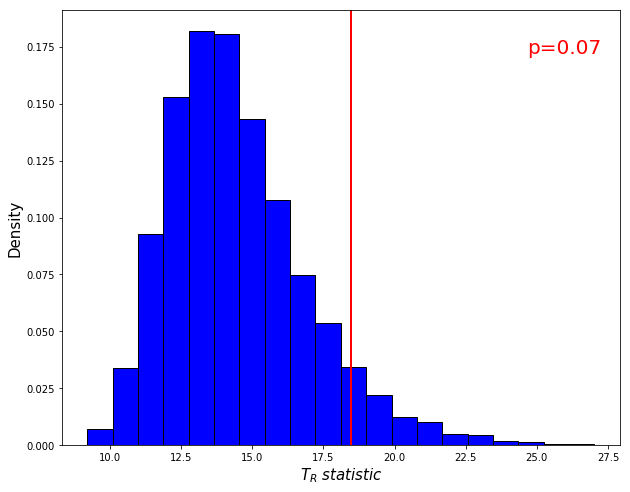

In [25]:
pc = n_TR/5000
p_TR = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TR_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_R_obs_092, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TR, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_R\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

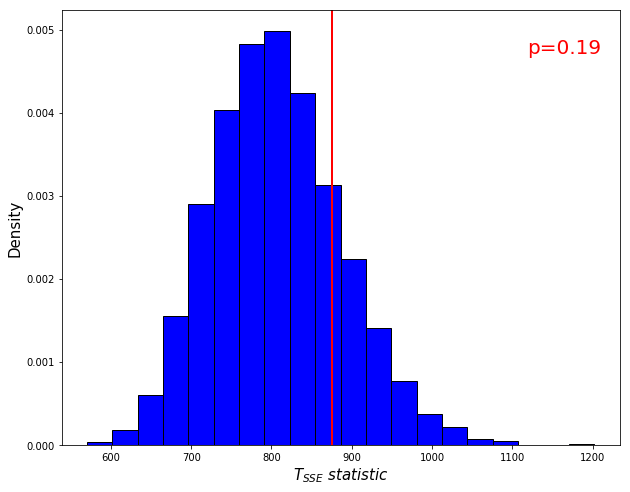

In [26]:
pc = n_TSSE/5000
p_TSSE = ("%.2f" % pc)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
plt.hist(TSSE_list, bins=20, density=True, color="b", edgecolor='k')
plt.axvline(T_SSE_obs_092, color="r", linewidth=2)
plt.text(0.9, 0.9,'p=%s'%p_TSSE, color='red', ha='center', transform=ax.transAxes, fontsize=20)
ax.set_xlabel("$T_{SSE}\ statistic$",fontsize=15)
ax.set_ylabel("Density",fontsize=15)
plt.show()

## 2009(2) 模型比较

In [27]:
def twi_minus_loglikelihood_nobreak_092(log_A,alpha,poisson):
    alpha_L = 1.0
    
    perdata092 = pd.read_csv("perlist092_s.csv")
    f = perdata092['f']
    per = perdata092['per']
            
    model = []
    f_length = len(f)
    for i in range(f_length):
        model.append((f[i]**(-alpha))*(10**log_A)+poisson)
     
    
    length = len(perdata092)
    minus_log_p = 0
    for i in range(length):
        minus_log_p += (per[i]/model[i]+math.log(model[i]))
    
    
    D = 2*minus_log_p
    # print (D)
    return D

In [28]:
n092=Minuit(twi_minus_loglikelihood_nobreak_092,log_A=-7,alpha=2.0,poisson=1.0,
         error_log_A=0.1,error_alpha=0.01,error_poisson=0.01,
         limit_log_A=(-9,-6),limit_alpha=(1.0,5.0),limit_poisson=(0,2),
         errordef=1)

n092.migrad()

pprint(n092.fval)

FCN = 2867.673885388583 
 TOTAL NCALL = 184 
 NCALLS = 184 
 
 
 EDM = 7.2657498840983565e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,log_A,-8.64809,0.77245,,,-9,-6,No
1,alpha,2.58107,0.229616,,,1,5,No
2,poisson,1.958,0.0716368,,,0,2,No


2867.673885388583


0.8591481509383811


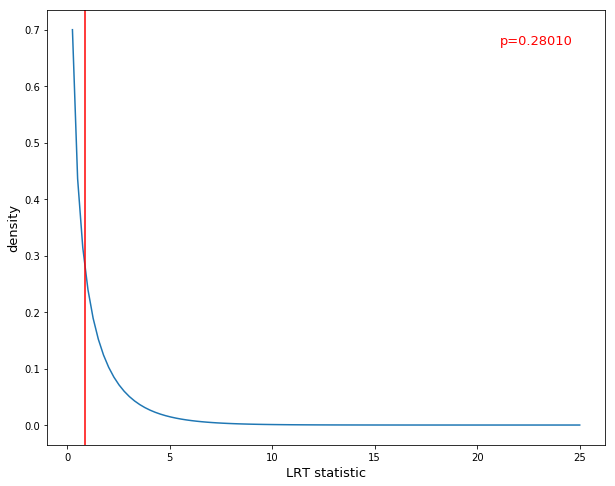

In [29]:
import scipy.stats as stats

# LRT statistic
T = n092.fval-m092.fval
print(T)

p = stats.chi2.pdf(T,1)
p1 = ("%.5f" % p)
plt.figure(figsize=(10,8))
plt.plot(np.linspace(0,25,100),stats.chi2.pdf(np.linspace(0,25,100),df=1))
plt.axvline(T,color="r")
plt.text(0.8,0.85,'p=%s'%p1,color='red',ha='center',transform=ax.transAxes,fontsize=13)
plt.xlabel("LRT statistic",fontsize=13)
plt.ylabel("density",fontsize=13)
plt.show()

## 综合结果

In [11]:
data06 = pd.read_csv("energy_2006.csv")  
x06 = data06['x']
y06 = data06['y']
xerr06 = data06['xerr']
yerr06 = data06['yerr']

data091 = pd.read_csv("energy_2009_1.csv")  
x091 = data091['x']
y091 = data091['y']
xerr091 = data091['xerr']
yerr091 = data091['yerr']

data092 = pd.read_csv("energy_2009_2.csv")  
x092 = data092['x']
y092 = data092['y']
xerr092 = data092['xerr']
yerr092 = data092['yerr']

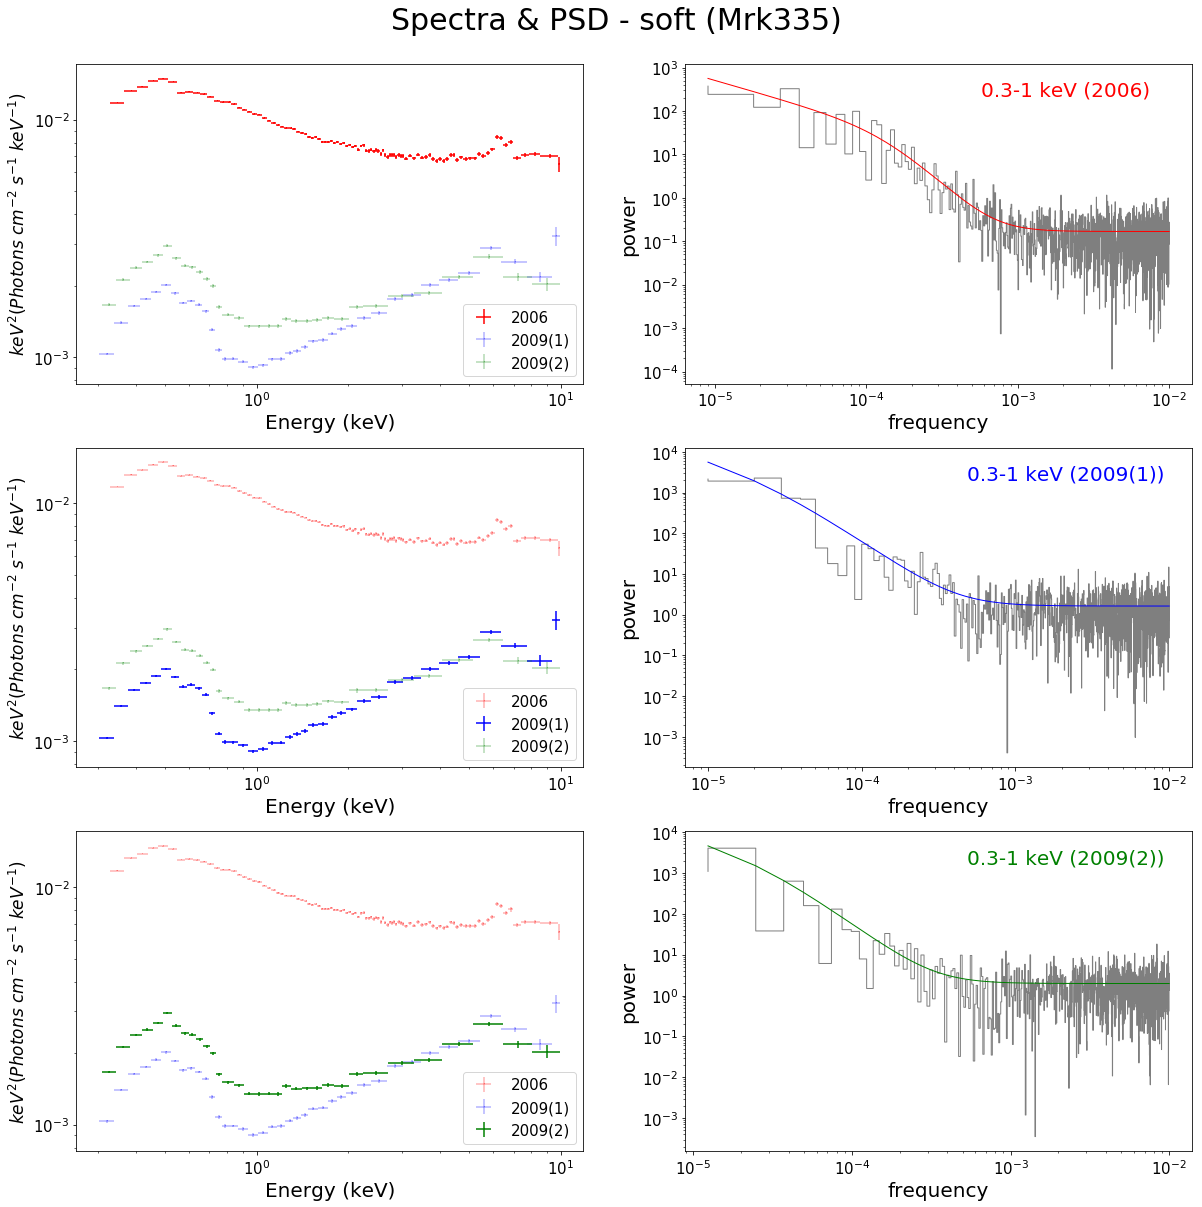

In [12]:
fig= plt.figure(figsize=(20,20))
ax1 = plt.subplot(321)
ax2 = plt.subplot(322)
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)
ax5 = plt.subplot(325)
ax6 = plt.subplot(326)



ax1.loglog()
ax1.errorbar(x06, y06, yerr=yerr06, xerr=xerr06, fmt=',r', label='2006')
ax1.errorbar(x091, y091, yerr=yerr091, xerr=xerr091, fmt=',b', alpha=0.3, label='2009(1)')
ax1.errorbar(x092, y092, yerr=yerr092, xerr=xerr092, fmt=',g', alpha=0.3, label='2009(2)')
ax1.set_xlabel("Energy (keV)",fontsize=20)
ax1.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax1.legend(fontsize=15)
ax1.tick_params(labelsize=15)

ax3.loglog()
ax3.errorbar(x06, y06, yerr=yerr06, xerr=xerr06, fmt=',r', alpha=0.3, label='2006')
ax3.errorbar(x091, y091, yerr=yerr091, xerr=xerr091, fmt=',b', label='2009(1)')
ax3.errorbar(x092, y092, yerr=yerr092, xerr=xerr092, fmt=',g', alpha=0.3, label='2009(2)')
ax3.set_xlabel("Energy (keV)",fontsize=20)
ax3.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax3.legend(fontsize=15)
ax3.tick_params(labelsize=15)

ax5.loglog()
ax5.errorbar(x06, y06, yerr=yerr06, xerr=xerr06, fmt=',r', alpha=0.3, label='2006')
ax5.errorbar(x091, y091, yerr=yerr091, xerr=xerr091, fmt=',b', alpha=0.3, label='2009(1)')
ax5.errorbar(x092, y092, yerr=yerr092, xerr=xerr092, fmt=',g', label='2009(2)')
ax5.set_xlabel("Energy (keV)",fontsize=20)
ax5.set_ylabel(r"$keV^2 (Photons{\ }cm^{-2}{\ } s^{-1}{\ } keV^{-1})$",fontsize=17)
ax5.legend(fontsize=15)
ax5.tick_params(labelsize=15)


ax2.loglog()
ax2.step(f_06, per_06, color="k", alpha=0.5, linewidth=1)
ax2.plot(f_06, model_06, color="r", linewidth=1)
ax2.set_xlabel("frequency",fontsize=20)
ax2.set_ylabel("power",fontsize=20)
ax2.text(0.75,0.9,"0.3-1 keV (2006)",color='r',ha='center',transform=ax2.transAxes,fontsize=20)
ax2.tick_params(labelsize=15)

ax4.loglog()
ax4.step(f_091, per_091, color="k", alpha=0.5, linewidth=1)
ax4.plot(f_091, model_091, color="b", linewidth=1)
ax4.set_xlabel("frequency",fontsize=20)
ax4.set_ylabel("power",fontsize=20)
ax4.text(0.75,-0.3,"0.3-1 keV (2009(1))",color='b',ha='center',transform=ax2.transAxes,fontsize=20)
ax4.tick_params(labelsize=15)

ax6.loglog()
ax6.step(f_092, per_092, color="k", alpha=0.5, linewidth=1)
ax6.plot(f_092, model_092, color="g", linewidth=1)
ax6.set_xlabel("frequency",fontsize=20)
ax6.set_ylabel("power",fontsize=20)
ax6.text(0.75,-1.5,"0.3-1 keV (2009(2))",color='g',ha='center',transform=ax2.transAxes,fontsize=20)
ax6.tick_params(labelsize=15)

plt.suptitle("Spectra & PSD - soft (Mrk335)", x=0.5, y=0.92, fontsize=30)
plt.show()

## 2006 MCMC

In [13]:
# 均匀先验

def lnprior(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -3 < log_A < -1 and -5 < log_f_b < -3 and 2.0 < alpha_H < 5.0 and 0.0 < poisson < 1.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_06(log_A,log_f_b,alpha_H,poisson))

In [14]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m06.values[0],m06.values[1],m06.values[2],m06.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 1819.6 seconds


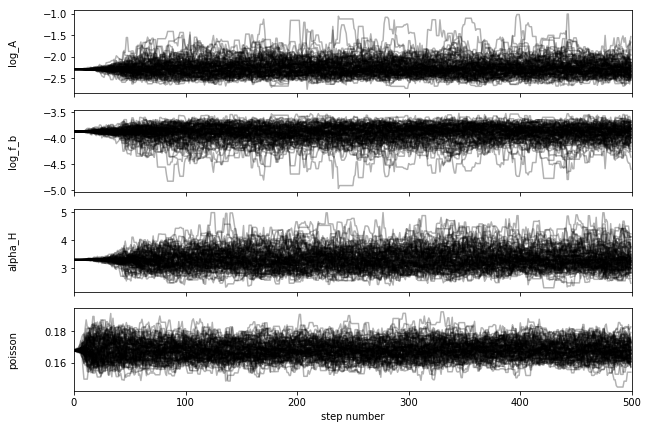

In [15]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [16]:
print ("Parameters (2006)")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2006)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

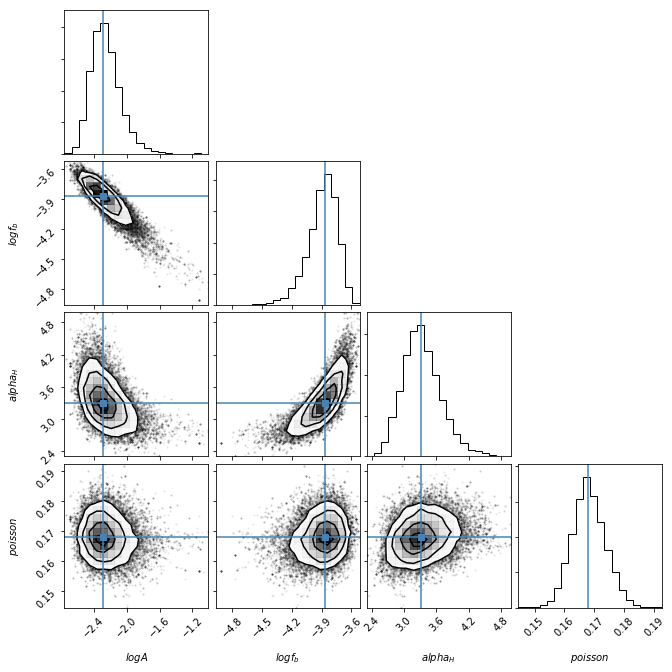

In [17]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m06.values[0], m06.values[1], m06.values[2], m06.values[3]])

## 2009(1) MCMC

In [18]:
# 均匀先验

def lnprior_091(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -3 < log_A < 1.0 and -8 < log_f_b < -3 and 1.0 < alpha_H < 5.0 and 0.0 < poisson < 3.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_091(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior_091(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_091(log_A,log_f_b,alpha_H,poisson))

In [19]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m091.values[0],m091.values[1],m091.values[2],m091.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_091)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 1456.0 seconds


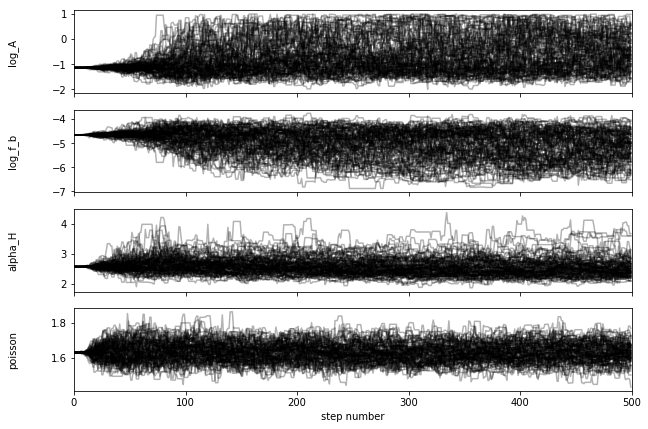

In [20]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [21]:
print ("Parameters (2009(1))")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2009(1))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

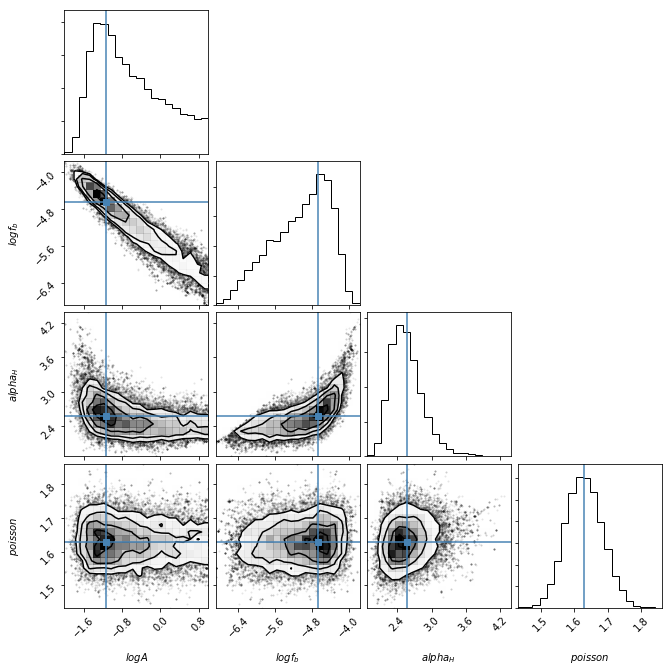

In [22]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m091.values[0], m091.values[1], m091.values[2], m091.values[3]])

## 2009(2) MCMC

In [23]:
# 均匀先验

def lnprior_092(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    alpha_L = 1.0
    if -3 < log_A < 1.0 and -8 < log_f_b < -3 and 1.0 < alpha_H < 5.0 and 0.0 < poisson < 3.0:
        return 0.0
    return -np.inf

# 后验概率？

def lnprob_092(theta):
    log_A,log_f_b,alpha_H,poisson = theta
    lp = lnprior_092(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp - 0.5* twi_minus_loglikelihood_092(log_A,log_f_b,alpha_H,poisson))

In [24]:
# emcee

ndim, nwalkers = 4, 100
pos = [[m092.values[0],m092.values[1],m092.values[2],m092.values[3]] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_092)


# 显示进度并记录时间
import sys

nsteps = 500
width = 30
start = time.time()
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    z = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * z, ' ' * (width - z)))
sys.stdout.write("\n")
end = time.time()
multi_time = end - start
print("Serial took {0:.1f} seconds".format(multi_time))

[##############################]
Serial took 1133.1 seconds


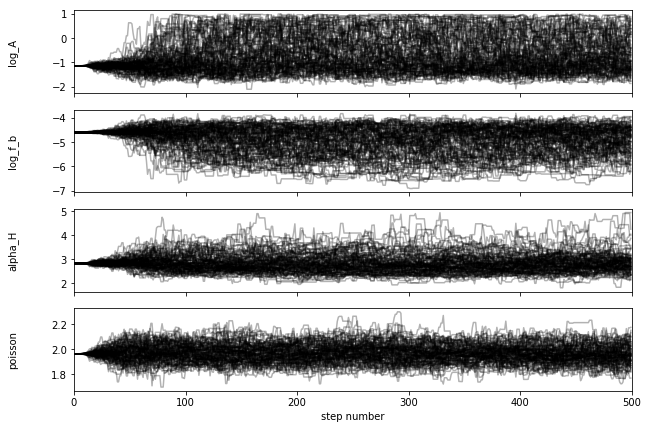

In [25]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["log_A", "log_f_b", "alpha_H","poisson"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.transpose(samples[:,:,i]), "k", alpha=0.3)
    ax.set_xlim(0, len(samples[1]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [26]:
print ("Parameters (2009(2))")

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

labels = ["log A", "log f_b", "alpha_H","poisson"]

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}} ^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

Parameters (2009(2))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

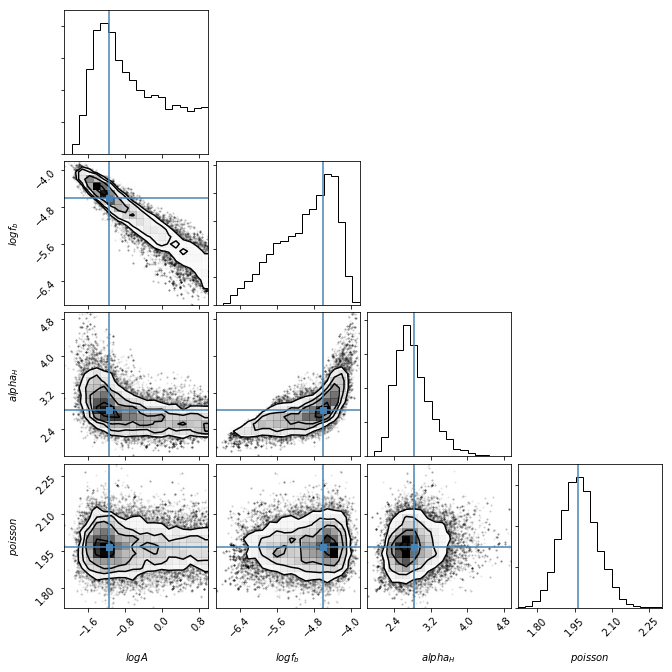

In [27]:
import corner
fig = corner.corner(samples, labels=["$log A$", "$log f_b$", "$alpha_H$", "$poisson$"],
                      truths=[m092.values[0], m092.values[1], m092.values[2], m092.values[3]])